# Exploratory Data Analysis (EDA)
This note book contains exploratory data analysis for the Amazon Book review data set we have extracted. It contains 2M reviews. Due to long processing time we have conducted the analysis on first 2M review only.  
But this code is written in a way that it can be expanded to accomodate rest of the dataset. We have also save the processed data frame and dictionary to external files where ever required. This can save the processing time while editing the outputs. 

*Please note: place the "amazon_review" file in "k_data" folder*

In [112]:
#code
#Required Imports
import pandas as pd
import re
from collections import Counter
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.corpus import stopwords
import gc
import numpy as np
import nltk
from matplotlib import pyplot as plt
import wordcloud as WordCloud

In [ ]:
#Use this code if running for the first time on on your PC
import nltk
nltk.download('punkt')
nltk.download('stopwords')

In [208]:
# Helps to supress the warnings
import warnings
warnings.filterwarnings('ignore')

## Method to read and preprocess the data

In [218]:
#Read the data
def read_data():
    data_l = pd.read_csv("k_data/amazon_reviews")

    #Step 1: preprocessing requires to convert given string time back to datetime object for further processing
    data_l["reviewTime"] = pd.to_datetime(data_l.reviewTime)

    #Step 2: preprocessing requires to remove na values
    data_l = data_l[data_l['reviewText'].notna()]
    
    return data_l

## Methods to support the analysis

In [106]:
#Custom funtions that are only suitable to run on Amazon review dataset. 

#Takes in df and just return the raw text
def combineComments(data):
    rawtext =  ' '.join(list(data['reviewText']))
    return rawtext

#Given a string removes punctuations and lower case all the words
def removePuncLower(s):
    re_tok = re.compile(r'[^\w]+')
    s = re_tok.sub(' ', s).lower()
    return s

#Given the string removes stop words in english language, for eg a, an, the, etc..
def removeStopwords(l):
    tokens_without_sw = [word for word in l if not word in set(stopwords.words("english"))]
    return tokens_without_sw

#Given the string removes stop words in english language, for eg a, an, the, etc..
def removeStopwords_dict(l):
    tokens_without_sw = [(word, cnt) for (word, cnt) in l if not word in set(stopwords.words("english"))]
    return tokens_without_sw

#Extract text and make it into a simple list
def textExtract(data):
    rawtext = list(data['reviewText'])
    flatlist = [item for sublist in data['reviewText'] for item in sublist]
    return flatlist

#Repetition of the extraction of text data and minimal preprocessing
def textExtract_str(data):
    data = data[data['reviewText'].notna()]
    rawtext =  ' '. join(list(data['reviewText']))
    return rawtext

#Compute the TFIDF and postprocess the data to make it suitable for wordcloud
def computeTFIDF(corpus, columnnames, dfmax):    
    vectorizer = TfidfVectorizer(stop_words = 'english',max_df=dfmax, use_idf = True)
    print("transforming...")
    X = vectorizer.fit_transform(corpus)
    print("getting feature name...")
    feature_names = vectorizer.get_feature_names()
    print("densing list...")
    dense = X.todense()
    denselist = dense.tolist()
    print("reshaping list...")
    new_list = [list(x) for x in zip(*denselist)]
    print("converting to data frame...")
    df = pd.DataFrame(new_list, index=feature_names, columns = columnnames)
    return df

## Generate count per rating per month 

In [212]:
#Read data
data_l = read_data()
#This code creates a dataframe that generate the count of raings per month
data_bym = pd.DataFrame(columns=['reviewTime'])
ratings = np.sort(data_l['overall'].unique())
data_bym_overall = []

for r in ratings:
    data = data_l.loc[data_l['overall']==r]
    data['reviewTime'] = data['reviewTime'].dt.to_period('M')
    data = data.groupby('reviewTime').reviewText.agg(['sum','count']).reset_index().rename(columns = {'sum':'reviewText'})
    data['reviewText'] = data[['reviewText']] .applymap(removePuncLower)
    data['reviewText'] = data[['reviewText']].applymap(word_tokenize)
    data["len_comments"] = data[['reviewText']].applymap(len)
    data["len_comments"] = data["len_comments"]/data['count']
    data_bym_rat = data.drop(columns = ['reviewText','count'])
    data_bym = pd.merge(data_bym, data_bym_rat, how='outer', on='reviewTime').rename(columns = {'len_comments' : r})
    print(r)
    

1.0
2.0
3.0
4.0
5.0


In [ ]:
#To save this data for future use
data_bym = data_bym.sort_values('reviewTime')
data_bym.to_csv("k_data/bym.csv",index=False)

In [ ]:
#Read the data from the saved file
data_bym = pd.read_csv("k_data/bym.csv")

In [169]:
data_bym

,reviewTime,1,2,3,4,5
256,1996-09,NaN,NaN,NaN,NaN,149.000000
252,1996-11,NaN,189.000000,NaN,NaN,NaN
257,1996-12,NaN,NaN,NaN,NaN,118.500000
0,1997-03,33.000000,266.000000,NaN,56.000000,NaN
1,1997-04,65.000000,25.000000,NaN,NaN,119.000000
...,...,...,...,...,...,...
247,2018-01,73.969697,93.825427,101.669194,97.111929,62.043265
248,2018-02,73.909657,91.912281,101.498840,98.378845,57.940312
249,2018-03,80.244186,91.648936,98.497468,103.035861,59.043773
250,2018-04,68.005208,94.544503,108.324051,105.240328,59.973072


## Code to generate graph for counts of rating per month

Took 40 minutes to compute the data for this graph 

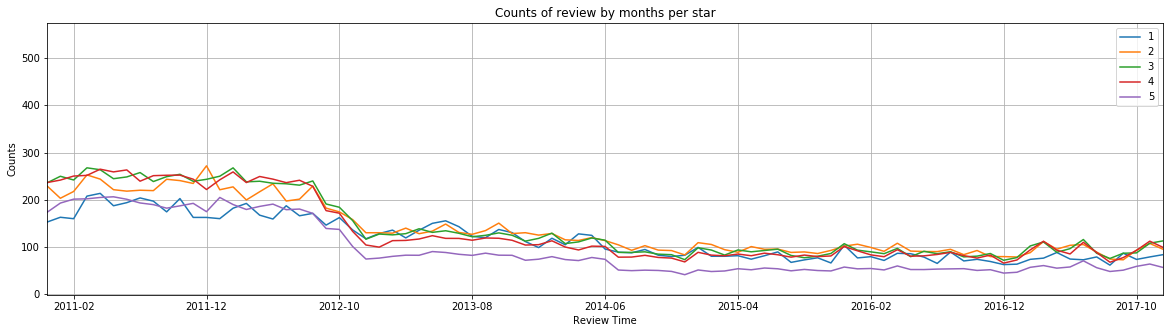

In [183]:
s_year = 2011
e_year = 2018
orig = 1996
diff = year-orig
start = diff*12
end = start+((e_year-s_year)*12)
xlim = (start,end)
data_bym.plot(figsize=(20,5),x='reviewTime',xlim=xlim)
plt.title("Counts of review by months per star")
plt.ylabel("Counts")
plt.xlabel("Review Time")
plt.grid()
plt.savefig("k_data/Counts_per_rating.png")
plt.show()

***

## Code to count the most frequent words for each ratings

In [219]:
#Read data
data = read_data()

data.columns

data['reviewTime'] = data['reviewTime'].dt.year

data = data.groupby('reviewTime').reviewText.agg('sum')

text_dict = data.to_dict()

for year in text_dict:
            freq_count = Counter(text_dict[year]).most_common(100)
            freq_count = sorted(removeStopwords_dict(freq_count), key = lambda x : x[1])[-10:]
            #plotFreqWords(freq_count, filelist[i] + '_' + str(year), ax_year, loc_i, loc_j)

data = pd.DataFrame(data)
text = textExtract(data)

del data

gc.collect()

freq_count = Counter(text).most_common(100)       
freq_count = sorted(removeStopwords_dict(freq_count), key = lambda x : x[1])[-10:]

freq_count


***

## Computing the distribution of ratings

In [74]:
#Read data
data = read_data()

count_dictionary={}
count_dictionary[0] = {"Department": "Book", 
                       "Count": data.shape[0],
                       "Product": data.asin.unique().shape[0]}
for score in [1.0, 2.0, 3.0, 4.0, 5.0]:
    x_star = str(int(score)) + "-star"
    count_dictionary[0][x_star] = data[data["overall"] == score].shape[0]
count_dictionary[0]["Verified"] = data[data["verified"] == True].shape[0]

In [82]:
count_dictionary

{0: {'Department': 'Book',
  'Count': 1999749,
  'Product': 29718,
  '1-star': 72506,
  '2-star': 90440,
  '3-star': 199015,
  '4-star': 441158,
  '5-star': 1196630,
  'Verified': 1353565}}

In [83]:
#Computing Rate of reviews and rate of verified reviews to display it on the graph
count_data = pd.DataFrame.from_dict(count_dictionary, orient="index")
count_data["Review_Rate"] = count_data.Count / count_data.Product
count_data["Verified_Rate"] = count_data.Verified/count_data.Count

#Code to save the data for future use
count_data.to_csv("k_data/count_data.csv")
#Reading the data from the external saved file
count_data = pd.read_csv("k_data/count_data.csv")

## Generating the graph of distributions of ratings

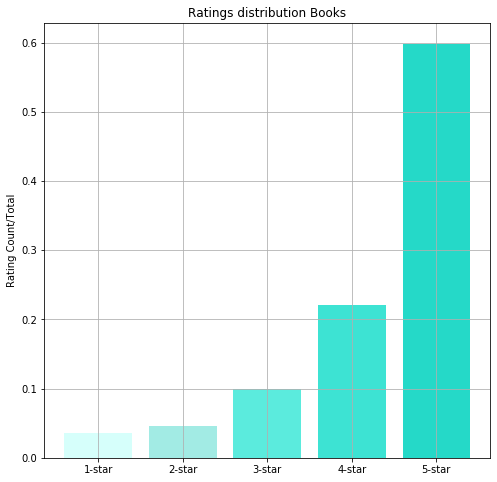

In [203]:

department_list = count_data.Department.tolist()

# Color labels
color_list = ["#d6fffb", "#a2ebe4", "#5bebdd", "#3de3d3", "#25d9c8"]

bar_loc = np.array(range(0, len(department_list) * 2, 2))
total_width, n = 1.5, 5
width = total_width / n


plt.figure(figsize=(8, 8))
for i, x_star in enumerate(["1-star", "2-star", "3-star", "4-star", "5-star"]):
    
    plt.bar(i, count_data[x_star] / count_data["Count"],color=color_list[i])
    
#plt.legend()
plt.xticks([0,1,2,3,4],["1-star", "2-star", "3-star", "4-star", "5-star"])
plt.ylabel("Rating Count/Total")
plt.title("Ratings distribution Books")
plt.grid()
plt.savefig('rating_ditribution.png')
plt.show()



***


## Computing verified and non verified review differences

In [89]:
#Read data
data = read_data()
verified_rating_dictionary = {}
verified_dict = {}
for verified in [True, False]:
        verified_data = data[data["verified"] == verified]
        score_dict = {}
        for score in [1.0, 2.0, 3.0, 4.0, 5.0]:
            x_star = str(int(score)) + "-star"
            score_dict[x_star] = verified_data[verified_data["overall"] == score].shape[0] / verified_data.shape[0]
        verified_dict[verified] = score_dict
        verified_rating_dictionary["Books"] = verified_dict

In [90]:
verified_rating_dictionary

{'Books': {True: {'1-star': 0.027312319689117258,
   '2-star': 0.03700376413397214,
   '3-star': 0.08764041623416681,
   '4-star': 0.20127810633401425,
   '5-star': 0.6467653936087295},
  False: {'1-star': 0.05499517165389425,
   '2-star': 0.0624481571812363,
   '3-star': 0.12440419447092468,
   '4-star': 0.2610943632154309,
   '5-star': 0.49705811347851386}}}

In [98]:
#Saving this dictionary for future use
np.save("k_data/verified_rating_dictionary.npy",verified_rating_dictionary)
#Loading the dictionary from an external file
verified_rating_dictionary = np.load("k_data/verified_rating_dictionary.npy",allow_pickle='TRUE').item()

## Ploting the graph for verified vs not verified review counts

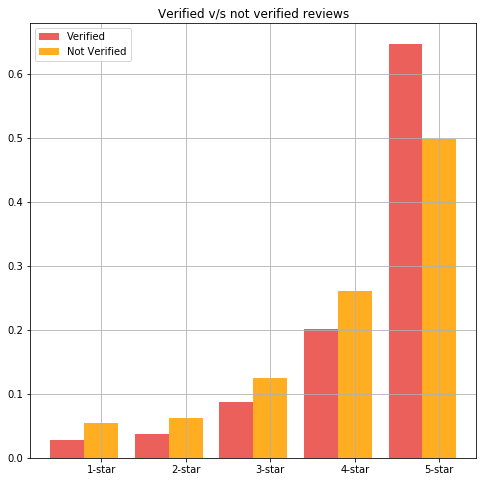

In [206]:
# X labels, score list
score_list = ["1-star", "2-star", "3-star", "4-star", "5-star"]

# Color labels
color_list = ["#eb605b", "#ffae21"]

plt.figure(figsize=(8, 8))
for i, department in enumerate(verified_rating_dictionary.keys()):

    test_data = verified_rating_dictionary[department]
    bar_loc = np.array(range(len(score_list)))
    total_width, n = 0.8, 2
    width = total_width / n
    tick_loc = bar_loc + width * (n / 2)
    
    #plt.subplot(20, 20, i + 1)
    for i, verified in enumerate([(True, "Verified"), (False, "Not Verified")]):
        plt.bar(bar_loc, np.array(list(test_data[verified[0]].values())), width=width, label=verified[1], color=color_list[i])
        bar_loc = bar_loc + width
    plt.legend()
    plt.xticks(tick_loc, score_list)
    plt.title("Verified v/s not verified reviews")
plt.grid()
plt.savefig("k_data/verified_vs_not_verified.png")
plt.show()



***

# Code to generate TFIDF word cloud

In [ ]:
#Read data
data = read_data()
#Sort the ratings 
ratings = np.sort(data['overall'].unique())
#Generate a list of text word for each rating category
doc_list = []
for r in ratings:
    data_l = data.loc[data['overall']==r]
    text = textExtract_str(data_l)
    text = removePuncLower(text)
    doc_list.append(text)  
***

#Code to save the generated file for future use
with open ('./k_data/doc_list.txt','w') as f:
    for item in doc_list:
        f.write("%s\n"%item)

In [210]:
 tfidf_df = computeTFIDF(doc_list, ratings, 0.99) 

transforming...
getting feature name...
densing list...
reshaping list...
converting to data frame...


1.0


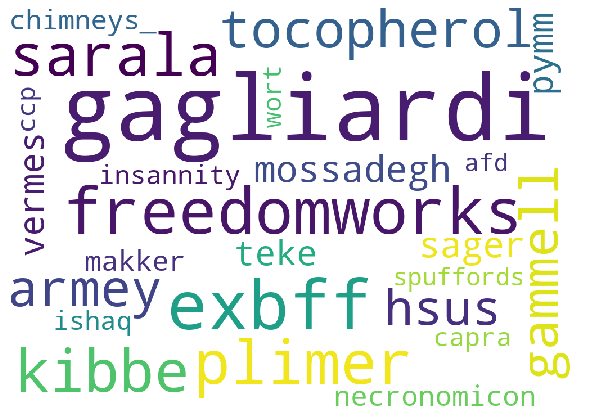

2.0


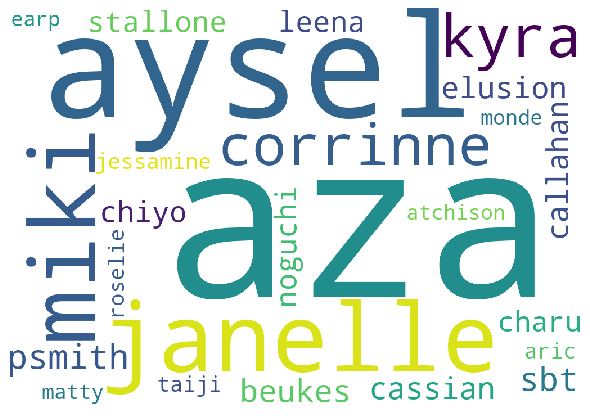

3.0


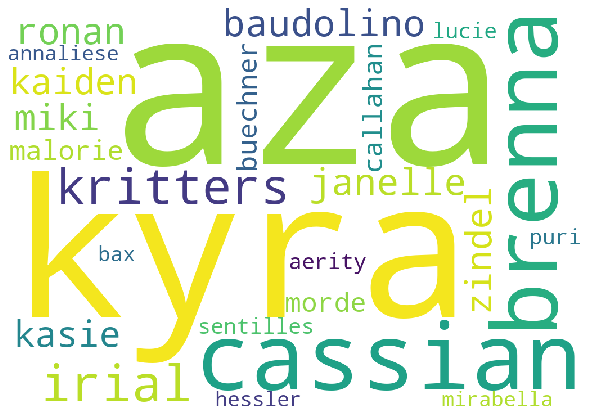

4.0


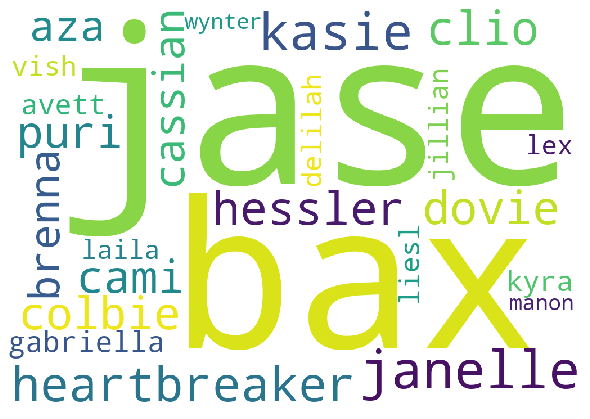

5.0


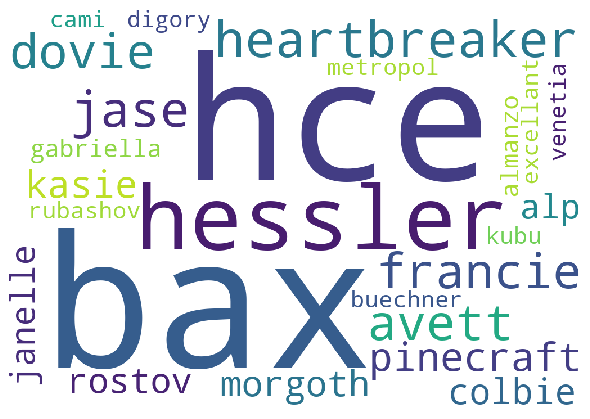

In [139]:
sp=stopwords.words("english")
for r in ratings:  
    print(r)
    top10 = tfidf_df[r].nlargest(25).index
    top10value = list(tfidf_df[r].nlargest(25))
    weights = {top10[i]:top10value[i] for i in range(25)}
    
    wc = WordCloud(
            background_color="white",
            max_words=2000,
            width = 1024,
            height = 720,
            stopwords=sp)
    wc.generate_from_frequencies(weights)
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wc) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.savefig("./k_data/test_"+str(int(r))+".png")
    plt.show() 

# Reference: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.bar.html?highlight=bar#matplotlib.pyplot.bar
# Reference: Part of this code was inspired from the, user's bellalalala repository DS5500-Amazon-Review_sentiment-Analysis https://github.com/bellalalala/DS5500-Amazon-Reviews-Sentiment-Analysis/blob/master/README.md 
# Reference: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html
# Reference: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.grid.html
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html